In [11]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

<module 'behavior.func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

## Endo

In [12]:
real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]
bands = [[8, 12], [12.5, 30], [30, 80]]
band_names = ['alpha', 'beta', 'gamma']
band_greek = ['α', 'β', 'γ']

diff_color = '#b8afe6'
font_size = 24
x_size = 9
y_size = 8.5
diff_x = 2.5
diff_y = -85


In [13]:
band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase %', 'real before', 'real after', 'real increase %'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]
compare_objects = ['alpha', 'beta', 'gamma']

case='3 | 4'
watch='1 fixation'
tmin = 0
tmax = 4.55

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase %'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase %'] = str(sham_increase)


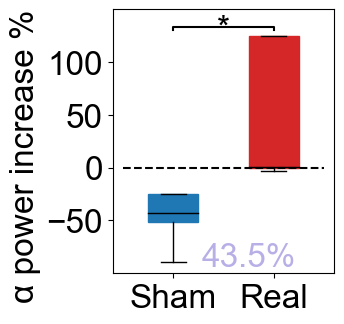

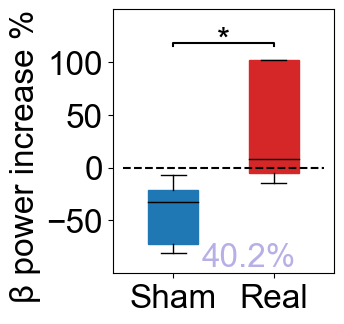

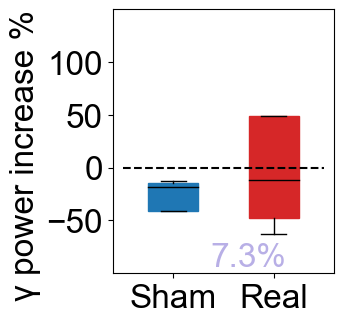

In [14]:
rc('font', family='Arial')
for i, compare_object in enumerate(band_names):
    watch = 'Endo'
    save_path = os.path.join('..', '..', '..','..','..', 'confNjral', 'EMBC2023', 'poster', 'figs', compare_object+'_'+watch+'.svg')

    diff_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase %'].apply(ast.literal_eval).values[0])
    diff_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase %'].apply(ast.literal_eval).values[0])

    # create boxplot
    fig, ax = plt.subplots(figsize=(x_size/2.54, y_size/2.54)) # Sizes are in inches
    boxplots = ax.boxplot([diff_sham, diff_real], patch_artist=True, widths=1, positions=[1,3], showfliers=False)

    # Set colors for the box plots
    colors = ['#1f77b4', '#d62728']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)

    # Set median line color to black
    for median in boxplots['medians']:
        median.set_color('black')

    plt.xticks([1, 3], ['Sham', 'Real'], fontsize=font_size)
    plt.yticks([-50, 0, 50, 100], fontsize=font_size)
    plt.ylabel(band_greek[i]+" power increase %   ", fontsize=font_size)
    plt.ylim(-100, 150)

    ax.hlines(0, 0, 4, colors='k', linestyles='dashed') # Adding a dashed line at y=0

    # Perform the Mann-Whitney U test
    U, p_value = stats.mannwhitneyu(diff_sham, diff_real)

    # Add significance line and asterisk
    y_max = max(diff_sham.max(), diff_real.max())  # Add some padding
    if i == 0:
        ax.text(2, 116, "*", ha='center', va='bottom', fontsize=font_size)

        # Draw the square bracket
        bracket_y_pos = 130
        bracket = mlines.Line2D([1, 1, 3, 3], [bracket_y_pos, bracket_y_pos+3, bracket_y_pos+3, bracket_y_pos], color='k')
        ax.add_line(bracket)
    elif i == 1:
        ax.text(2, 105, "*", ha='center', va='bottom', fontsize=font_size)

        # Draw the square bracket
        bracket_y_pos = 115
        bracket = mlines.Line2D([1, 1, 3, 3], [bracket_y_pos, bracket_y_pos+3, bracket_y_pos+3, bracket_y_pos], color='k')
        ax.add_line(bracket)

    # Draw arrow between medians and annotate it
    medians = [line.get_ydata()[0] for line in boxplots['medians']]  # get medians
    median_diff = medians[1] - medians[0]  # calculate difference    # arrow = patches.FancyArrow(1, medians[0], 1.9, medians[1]-medians[0], width=0.02, color='#6a4c93', length_includes_head=True)
    # ax.add_patch(arrow)
    ax.text(diff_x, diff_y, f"{median_diff:.1f}%", ha='center', va='center', fontsize=font_size, color=diff_color)

    plt.tight_layout()  # Adjust layout to fit labels
    plt.savefig(save_path, format='svg')

    plt.show()


## Exo

In [15]:
band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase %', 'real before', 'real after', 'real increase %'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]
compare_objects = ['alpha', 'beta', 'gamma']

case='5 | 6'
watch='1 fixation'
tmin = 0
tmax = 2.5

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase %'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase %'] = str(sham_increase)


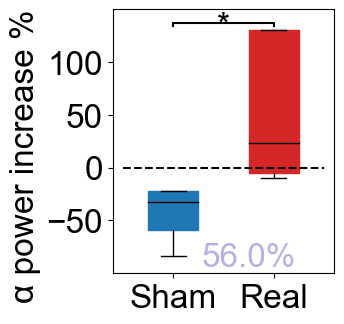

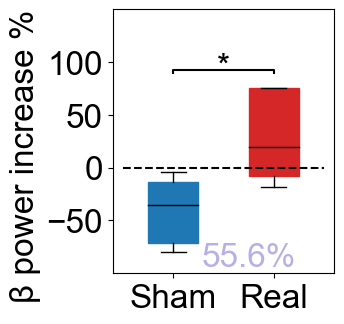

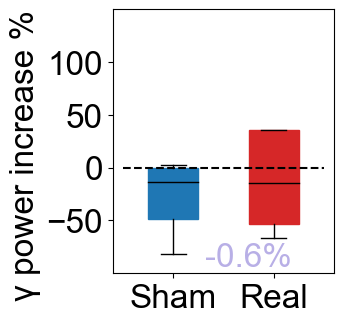

In [18]:
rc('font', family='Arial')
for i, compare_object in enumerate(band_names):
    watch = 'Exo'
    save_path = os.path.join('..', '..', '..','..','..', 'confNjral', 'EMBC2023', 'poster', 'figs', compare_object+'_'+watch+'.svg')

    diff_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase %'].apply(ast.literal_eval).values[0])
    diff_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase %'].apply(ast.literal_eval).values[0])

    # create boxplot
    fig, ax = plt.subplots(figsize=(x_size/2.54, y_size/2.54)) # Sizes are in inches
    boxplots = ax.boxplot([diff_sham, diff_real], patch_artist=True, widths=1, positions=[1,3], showfliers=False)

    # Set colors for the box plots
    colors = ['#1f77b4', '#d62728']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)

    # Set median line color to black
    for median in boxplots['medians']:
        median.set_color('black')

    plt.xticks([1, 3], ['Sham', 'Real'], fontsize=font_size)
    plt.yticks([-50, 0, 50, 100], fontsize=font_size)
    plt.ylabel(band_greek[i]+" power increase %   ", fontsize=font_size)
    plt.ylim(-100, 150)

    ax.hlines(0, 0, 4, colors='k', linestyles='dashed') # Adding a dashed line at y=0

    # Perform the Mann-Whitney U test
    U, p_value = stats.mannwhitneyu(diff_sham, diff_real)

    # Add significance line and asterisk
    y_max = max(diff_sham.max(), diff_real.max())  # Add some padding
    if i == 0:
        ax.text(2, 119, "*", ha='center', va='bottom', fontsize=font_size)

        # Draw the square bracket
        bracket_y_pos = 134
        bracket = mlines.Line2D([1, 1, 3, 3], [bracket_y_pos, bracket_y_pos+3, bracket_y_pos+3, bracket_y_pos], color='k')
        ax.add_line(bracket)
    elif i == 1:
        ax.text(2, 80, "*", ha='center', va='bottom', fontsize=font_size)

        # Draw the square bracket
        bracket_y_pos = 90
        bracket = mlines.Line2D([1, 1, 3, 3], [bracket_y_pos, bracket_y_pos+3, bracket_y_pos+3, bracket_y_pos], color='k')
        ax.add_line(bracket)

    # Draw arrow between medians and annotate it
    medians = [line.get_ydata()[0] for line in boxplots['medians']]  # get medians
    median_diff = medians[1] - medians[0]  # calculate difference
    # arrow = patches.FancyArrow(1, medians[0], 1.9, medians[1]-medians[0], width=0.02, color='#6a4c93', length_includes_head=True)
    # ax.add_patch(arrow)
    ax.text(diff_x, diff_y, f"{median_diff:.1f}%", ha='center', va='center', fontsize=font_size, color=diff_color)

    plt.tight_layout()  # Adjust layout to fit labels
    plt.savefig(save_path, format='svg')

    plt.show()
